In [2]:
print("Hello World!")

Hello World!


### 1. Select an LLM

In [2]:
import os
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model

load_dotenv()
api_key = os.getenv('GEMINI_API_KEY')

model = init_chat_model("google_genai:gemini-3-flash-preview", api_key=api_key)

### 2. Configure the database

##### 2.1. Create DB

In [4]:
import sqlite3

# إنشاء ملف قاعدة بيانات جديد (لو مش موجود)
conn = sqlite3.connect("appointments.db")
cursor = conn.cursor()


In [5]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS appointments (
    date TEXT,
    time TEXT,
    service TEXT,
    status TEXT,
    customer_name TEXT,
    phone TEXT
)
""")


In [ ]:
# بيانات الأسبوع: كل يوم فيه 4 مواعيد
appointments = [
    # يوم 10 يناير
    ("2025-01-10", "15:00", "Consultation", "Available", "", ""),
    ("2025-01-10", "16:00", "Consultation", "Booked", "Ahmed Ali", "010..."),
    ("2025-01-10", "17:00", "Consultation", "Available", "", ""),
    ("2025-01-10", "18:00", "Consultation", "Booked", "Sara Mohamed", "011..."),

    # يوم 11 يناير
    ("2025-01-11", "15:00", "Consultation", "Available", "", ""),
    ("2025-01-11", "16:00", "Consultation", "Booked", "Omar Hassan", "012..."),
    ("2025-01-11", "17:00", "Consultation", "Available", "", ""),
    ("2025-01-11", "18:00", "Consultation", "Booked", "Mona Adel", "010..."),

    # يوم 12 يناير
    ("2025-01-12", "15:00", "Consultation", "Booked", "Ali Mostafa", "015..."),
    ("2025-01-12", "16:00", "Consultation", "Available", "", ""),
    ("2025-01-12", "17:00", "Consultation", "Available", "", ""),
    ("2025-01-12", "18:00", "Consultation", "Booked", "Nour Samir", "011..."),

    # يوم 13 يناير
    ("2025-01-13", "15:00", "Consultation", "Available", "", ""),
    ("2025-01-13", "16:00", "Consultation", "Booked", "Hassan Ali", "010..."),
    ("2025-01-13", "17:00", "Consultation", "Available", "", ""),
    ("2025-01-13", "18:00", "Consultation", "Booked", "Layla Ahmed", "012..."),

    # يوم 14 يناير
    ("2025-01-14", "15:00", "Consultation", "Booked", "Karim Youssef", "013..."),
    ("2025-01-14", "16:00", "Consultation", "Available", "", ""),
    ("2025-01-14", "17:00", "Consultation", "Available", "", ""),
    ("2025-01-14", "18:00", "Consultation", "Booked", "Fatma Ali", "010..."),

    # يوم 15 يناير
    ("2025-01-15", "15:00", "Consultation", "Available", "", ""),
    ("2025-01-15", "16:00", "Consultation", "Booked", "Mahmoud Saleh", "011..."),
    ("2025-01-15", "17:00", "Consultation", "Available", "", ""),
    ("2025-01-15", "18:00", "Consultation", "Booked", "Aya Hassan", "012..."),

    # يوم 16 يناير
    ("2025-01-16", "15:00", "Consultation", "Booked", "Mostafa Ali", "010..."),
    ("2025-01-16", "16:00", "Consultation", "Available", "", ""),
    ("2025-01-16", "17:00", "Consultation", "Available", "", ""),
    ("2025-01-16", "18:00", "Consultation", "Booked", "Reem Mohamed", "015..."),
]

# إدخال البيانات كلها مرة واحدة
cursor.executemany("""
INSERT INTO appointments (date, time, service, status, customer_name, phone)
VALUES (?, ?, ?, ?, ?, ?)
""", appointments)

# # الصف الأول (موعد متاح)
# cursor.execute("""
# INSERT INTO appointments (date, time, service, status, customer_name, phone)
# VALUES (?, ?, ?, ?, ?, ?)
# """, ("2025-01-10", "15:00", "Consultation", "Available", "", ""))

# # الصف الثاني (موعد محجوز)
# cursor.execute("""
# INSERT INTO appointments (date, time, service, status, customer_name, phone)
# VALUES (?, ?, ?, ?, ?, ?)
# """, ("2025-01-10", "16:00", "Consultation", "Booked", "Ahmed Ali", "010..."))


In [7]:
conn.commit()
conn.close()

##### 2.2. SQL database wrapper

In [10]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///appointments.db")

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM appointments LIMIT 5;")}')

Dialect: sqlite
Available tables: ['appointments']
Sample output: [('2025-01-10', '15:00', 'Consultation', 'Available', '', ''), ('2025-01-10', '16:00', 'Consultation', 'Booked', 'Ahmed Ali', '010...'), ('2025-01-10', '17:00', 'Consultation', 'Available', '', ''), ('2025-01-10', '18:00', 'Consultation', 'Booked', 'Sara Mohamed', '011...'), ('2025-01-11', '15:00', 'Consultation', 'Available', '', '')]


### 3. Add tools for database interactions

In [11]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=model)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



### 4. Define application steps

In [17]:
from typing import Literal

from langchain.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode


# get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
# get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# # Example: create a predetermined tool call
# def list_tables(state: MessagesState):
#     tool_call = {
#         "name": "sql_db_list_tables",
#         "args": {},
#         "id": "abc123",
#         "type": "tool_call",
#     }
#     tool_call_message = AIMessage(content="", tool_calls=[tool_call])

#     list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
#     tool_message = list_tables_tool.invoke(tool_call)
#     response = AIMessage(f"Available tables: {tool_message.content}")

#     return {"messages": [tool_call_message, tool_message, response]}


# # Example: force a model to create a tool call
# def call_get_schema(state: MessagesState):
#     # Note that LangChain enforces that all models accept `tool_choice="any"`
#     # as well as `tool_choice=<string name of tool>`.
#     llm_with_tools = model.bind_tools([get_schema_tool], tool_choice="any")
#     response = llm_with_tools.invoke(state["messages"])

#     return {"messages": [response]}


# generate_query_system_prompt = """
# You are an agent designed to interact with a SQL database.
# Given an input question, create a syntactically correct {dialect} query to run,
# then look at the results of the query and return the answer. Unless the user
# specifies a specific number of examples they wish to obtain, always limit your
# query to at most {top_k} results.

# You can order the results by a relevant column to return the most interesting
# examples in the database. Never query for all the columns from a specific table,
# only ask for the relevant columns given the question.

# DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
# """.format(
#     dialect=db.dialect,
#     top_k=5,
# )
# 3) System prompt مخصص للمواعيد والحجز
generate_query_system_prompt = f"""
You are an agent designed to interact with an appointments database.
The database has a table 'appointments' with columns:
(date, time, service, status, customer_name, phone).

Your tasks:
- Answer questions about available or booked appointments.
- Suggest alternative times if a requested slot is not available.
- When booking, collect customer_name and phone, then confirm with the user.
- Only after explicit confirmation, update the appointment status to 'Booked'
  and fill in customer_name and phone.
- You may use SELECT to check availability and UPDATE to confirm bookings.
Never use DELETE or DROP statements.
"""


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = model.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


# check_query_system_prompt = """
# You are a SQL expert with a strong attention to detail.
# Double check the {dialect} query for common mistakes, including:
# - Using NOT IN with NULL values
# - Using UNION when UNION ALL should have been used
# - Using BETWEEN for exclusive ranges
# - Data type mismatch in predicates
# - Properly quoting identifiers
# - Using the correct number of arguments for functions
# - Casting to the correct data type
# - Using the proper columns for joins

# If there are any of the above mistakes, rewrite the query. If there are no mistakes,
# just reproduce the original query.

# You will call the appropriate tool to execute the query after running this check.
# """.format(dialect=db.dialect)
# 5) مراجعة الاستعلام قبل التنفيذ (للتأكد من صحته)
check_query_system_prompt = f"""
You are a SQL expert. Double check the {db.dialect} query for mistakes.
If correct, reproduce it. If not, fix it.
Allowed statements: SELECT, UPDATE on appointments table.
"""

def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = model.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

### 5. Implement the agent

In [19]:
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    """لو الرسالة الأخيرة فيها tool call نروح نراجع الاستعلام، لو لأ نوقف"""
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"

# بناء الـ workflow
builder = StateGraph(MessagesState)

# العقد الأساسية
builder.add_node(generate_query)          # توليد استعلام (SELECT / UPDATE)
builder.add_node(check_query)             # مراجعة الاستعلام
builder.add_node(run_query_node, "run_query")  # تنفيذ الاستعلام

# البداية → توليد استعلام
builder.add_edge(START, "generate_query")

# لو فيه tool call → نراجع الاستعلام
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)

# بعد المراجعة → تنفيذ الاستعلام
builder.add_edge("check_query", "run_query")

# بعد التنفيذ → نرجع تاني لتوليد استعلام (عشان الحوار يستمر)
builder.add_edge("run_query", "generate_query")

# بناء الـ agent
agent = builder.compile()

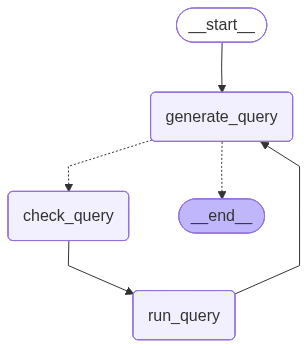

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [22]:
question = "ممكن تحجزلى يوم 14 يناير الساعة 4:00 عصراً؟ اسمي خالد محمد ورقم تليفوني 01012345678."

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

ممكن تحجزلى يوم 14 يناير الساعة 4:00 عصراً؟ اسمي خالد محمد ورقم تليفوني 01012345678.
================================== Ai Message ==================================

[]
Tool Calls:
  sql_db_query (3c39891c-4c87-4909-9fdd-bb92878439d4)
 Call ID: 3c39891c-4c87-4909-9fdd-bb92878439d4
  Args:
    query: SELECT * FROM appointments WHERE date = '2025-01-14' AND time = '16:00:00'
================================== Ai Message ==================================

[]
Tool Calls:
  sql_db_query (a6c7aaee-381e-40c5-bf58-1b1b483196ed)
 Call ID: a6c7aaee-381e-40c5-bf58-1b1b483196ed
  Args:
    query: SELECT name FROM sqlite_master WHERE type='table';
================================= Tool Message =================================
Name: sql_db_query

[('appointments',)]
================================== Ai Message ==================================

[]
Tool Calls:
  sql_db_query (e5bc5718-1287-4c00-ae8c-f48fbd4d4184)
 

KeyboardInterrupt: 

# New Abratch 

### Build Tools

In [5]:
import sqlite3
from langchain.tools import tool

DB_PATH = r"../data/appointments.db"


# ----------------------------
# Core DB functions (callable)
# ----------------------------
def _get_conn():
    """Create a SQLite connection (simple helper)."""
    return sqlite3.connect(DB_PATH)


def core_list_available_slots(service: str, date: str) -> list[str]:
    """Return available times (HH:MM) for a given service and date."""
    conn = _get_conn()
    cur = conn.cursor()
    cur.execute(
        """
        SELECT time
        FROM appointments
        WHERE service = ?
          AND date = ?
          AND status = 'free'
        ORDER BY time;
        """,
        (service, date),
    )
    rows = cur.fetchall()
    conn.close()
    return [r[0] for r in rows]


def core_check_slot_availability(service: str, date: str, time: str) -> str:
    """Return: 'available', 'booked', or 'not_found'."""
    conn = _get_conn()
    cur = conn.cursor()
    cur.execute(
        """
        SELECT status
        FROM appointments
        WHERE service = ? AND date = ? AND time = ?;
        """,
        (service, date, time),
    )
    row = cur.fetchone()
    conn.close()

    if row is None:
        return "not_found"
    return "available" if row[0] == "free" else "booked"


def core_book_slot(service: str, date: str, time: str, customer_name: str, phone: str) -> str:
    """Book slot using an atomic update. Returns a human-readable result."""
    conn = _get_conn()
    cur = conn.cursor()

    cur.execute(
        """
        UPDATE appointments
        SET status='booked',
            customer_name=?,
            phone=?,
            created_at=datetime('now')
        WHERE service=? AND date=? AND time=? AND status='free';
        """,
        (customer_name, phone, service, date, time),
    )

    conn.commit()
    updated = cur.rowcount
    conn.close()

    if updated == 1:
        return "success"

    # If update failed, distinguish booked vs not_found
    return core_check_slot_availability(service, date, time)


# ----------------------------
# LangChain Tools (wrappers)
# ----------------------------
@tool
def list_available_slots(service: str, date: str) -> str:
    """
    List available appointment times for a given service and date.
    date format: "YYYY-MM-DD"
    Returns a newline-separated list of available times (HH:MM).
    """
    times = core_list_available_slots(service, date)
    if not times:
        return f"No available slots found for '{service}' on {date}."
    return "Available times:\n" + "\n".join(times)


@tool
def check_slot_availability(service: str, date: str, time: str) -> str:
    """
    Check if a specific slot is available or booked.
    date format: "YYYY-MM-DD"
    time format: "HH:MM"
    Returns: "available", "booked", or "not_found"
    """
    return core_check_slot_availability(service, date, time)


@tool
def book_slot(service: str, date: str, time: str, customer_name: str, phone: str) -> str:
    """
    Book a slot if it is currently free (atomic update).
    date format: "YYYY-MM-DD"
    time format: "HH:MM"
    Returns a confirmation message or an error reason.
    """
    result = core_book_slot(service, date, time, customer_name, phone)

    if result == "success":
        return (
            f"Booking confirmed.\n"
            f"Service: {service}\n"
            f"Date: {date}\n"
            f"Time: {time}\n"
            f"Customer: {customer_name}\n"
            f"Phone: {phone}\n"
            f"Duration: 30 minutes"
        )

    if result == "booked":
        return "Sorry, that slot is already booked. Please choose another available time."
    if result == "not_found":
        return "Sorry, that slot does not exist in the schedule. Please ask for available times."

    return "Sorry, I could not complete the booking. Please try another slot."


In [8]:
"""
Simple tool tests for SQLite appointment tools.

Prerequisites:
1) Run your seed script first to create appointments.db with January 2026 data.
2) Ensure DB_PATH in tools matches the DB file path.
"""

from pprint import pprint

# Import your tools (adjust import path as needed)
# Example: from tools import list_available_slots, check_slot_availability, book_slot
# from tools import list_available_slots, check_slot_availability, book_slot


def test_list_available_slots():
    """Test listing available slots for a service on a date."""
    service = "Practice Growth Consultation"
    date = "2026-01-05"

    print("\n=== TEST: list_available_slots ===")
    result = list_available_slots.invoke({"service": service, "date": date})
    print(result)


def test_check_slot_availability():
    """Test checking a specific slot status."""
    service = "Practice Growth Consultation"
    date = "2026-01-01"
    time = "10:00"  # must match your SERVICE_TIME_MAP in seed

    print("\n=== TEST: check_slot_availability ===")
    result = check_slot_availability.invoke({"service": service, "date": date, "time": time})
    print("Status:", result)  # expected: available/booked/not_found


def test_book_slot():
    """Test booking a slot (should change status from free -> booked)."""
    service = "Practice Growth Consultation"
    date = "2026-01-01"
    time = "10:00"

    print("\n=== TEST: book_slot (first attempt) ===")
    result1 = book_slot.invoke({
        "service": service,
        "date": date,
        "time": time,
        "customer_name": "Test User",
        "phone": "+201012345678",
        "notes": "Demo booking test"
    })
    print(result1)

    print("\n=== TEST: book_slot (second attempt - should fail if already booked) ===")
    result2 = book_slot.invoke({
        "service": service,
        "date": date,
        "time": time,
        "customer_name": "Another User",
        "phone": "+201099999999",
        "notes": "Should not override existing booking"
    })
    print(result2)

    print("\n=== TEST: check_slot_availability (after booking) ===")
    status = check_slot_availability.invoke({"service": service, "date": date, "time": time})
    print("Status after booking:", status)  # expected: booked


if __name__ == "__main__":
    # Run tests
    test_list_available_slots()
    test_check_slot_availability()
    test_book_slot()



=== TEST: list_available_slots ===
Available times:
10:00

=== TEST: check_slot_availability ===
Status: available

=== TEST: book_slot (first attempt) ===
Booking confirmed.
Service: Practice Growth Consultation
Date: 2026-01-01
Time: 10:00
Customer: Test User
Phone: +201012345678
Duration: 30 minutes

=== TEST: book_slot (second attempt - should fail if already booked) ===
Sorry, that slot is already booked. Please choose another available time.

=== TEST: check_slot_availability (after booking) ===
Status after booking: booked


In [ ]:
"""
LangGraph demo:
- Router (decision) node
- General chat node
- Booking flow (LLM + tools loop)
- Handoff node (frustration/escalation) + flag
- Short-term memory using InMemorySaver + thread_id

Comments are in English (as requested).
"""

from __future__ import annotations

from typing import Annotated, Literal, Optional, Dict, Any
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver

# Your tools (LangChain @tool wrappers)
from tools import list_available_slots, check_slot_availability, book_slot


# ----------------------------
# 1) State (with short-term memory)
# ----------------------------
class State(TypedDict):
    # add_messages reducer appends new messages and also supports message updates by ID.
    messages: Annotated[list[AnyMessage], add_messages]

    # Router decision
    route: Literal["general", "booking", "handoff"]

    # Handoff flag (set True when user is frustrated / wants human)
    handoff_required: bool
    handoff_reason: str


# ----------------------------
# 2) LLMs
# ----------------------------
# General LLM (no tools)
general_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)

# Booking LLM (with tools)
booking_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.2)

TOOLS = [list_available_slots, check_slot_availability, book_slot]
TOOLS_BY_NAME = {t.name: t for t in TOOLS}

booking_llm_with_tools = booking_llm.bind_tools(TOOLS)


# ----------------------------
# 3) Router Node (Decision Maker)
# ----------------------------
# We mix lightweight rules + optional LLM fallback.
# This keeps routing stable in a demo.

FRUSTRATION_KEYWORDS = [
    "مش شغال", "مش نافع", "مش فاهم", "غلط", "سيء", "زبالة", "انت فاشل",
    "انت مش بتساعد", "مش قادر", "زهقت", "محبط", "متعصب", "غبي",
    "human", "agent", "بني ادم", "موظف", "حد يكلمني", "حد يرد"
]

BOOKING_KEYWORDS = [
    "احجز", "حجز", "موعد", "ميعاد", "مواعيد", "متاح", "available",
    "schedule", "appointment", "book", "booking", "reschedule", "الغاء", "تغيير"
]

GREETING_KEYWORDS = [
    "hi", "hello", "hey", "السلام", "سلام", "ازيك", "صباح", "مساء", "اهلا", "مرحبا"
]


def router_node(state: State) -> Dict[str, Any]:
    """
    Decide which path the user should go to:
    - general: greetings / general chat / unclear
    - booking: availability / propose time / booking flow
    - handoff: frustrated / wants a human / bot can't help
    """
    last_msg = state["messages"][-1]
    text = (last_msg.content or "").strip().lower()

    # 1) Hard rules first (reliable in demos)
    if any(k in text for k in FRUSTRATION_KEYWORDS):
        return {"route": "handoff", "handoff_required": True, "handoff_reason": "user_frustrated_or_requests_human"}

    if any(k in text for k in BOOKING_KEYWORDS):
        return {"route": "booking", "handoff_required": False, "handoff_reason": ""}

    if any(k in text for k in GREETING_KEYWORDS):
        return {"route": "general", "handoff_required": False, "handoff_reason": ""}

    # 2) Default to general (general node will ask 1 clarification if needed)
    return {"route": "general", "handoff_required": False, "handoff_reason": ""}


def route_from_state(state: State) -> Literal["general_node", "booking_llm_node", "handoff_node"]:
    """Conditional edge function based on router decision."""
    if state["route"] == "booking":
        return "booking_llm_node"
    if state["route"] == "handoff":
        return "handoff_node"
    return "general_node"


# ----------------------------
# 4) General Node (Chat / Greeting / Clarify)
# ----------------------------
GENERAL_SYSTEM = SystemMessage(
    content=(
        "You are a customer-care assistant for COB Solution.\n"
        "Speak Arabic in an Egyptian-friendly tone.\n"
        "If the user greets you, greet back and offer help.\n"
        "If the message is unclear, ask ONE short clarification question.\n"
        "If the user wants booking/availability, tell them you can help and ask for service/date if missing.\n"
        "Keep responses concise and natural."
    )
)


def general_node(state: State) -> Dict[str, Any]:
    """Respond without tools."""
    msgs = [GENERAL_SYSTEM] + state["messages"]
    ai = general_llm.invoke(msgs)
    return {"messages": [ai]}


# ----------------------------
# 5) Booking Flow (LLM decides tool calls -> tool executor -> loop)
# ----------------------------
BOOKING_SYSTEM = SystemMessage(
    content=(
        "You are a booking assistant for COB Solution (demo).\n"
        "Speak Arabic (Egyptian-friendly).\n"
        "Your job: help the user view availability, check a proposed time, and book.\n"
        "Rules:\n"
        "- NEVER invent availability. Use tools.\n"
        "- Duration is fixed: 30 minutes.\n"
        "- Required booking fields: service, date(YYYY-MM-DD), time(HH:MM), customer_name, phone.\n"
        "- If fields are missing, ask ONE short question to collect the missing info.\n"
        "- After tools run, respond naturally explaining what happened.\n"
        "Services (use exact names when calling tools):\n"
        "1) Practice Growth Consultation\n"
        "2) RCM / Billing & Denials Review\n"
        "3) Benefits Verification & Authorization Setup\n"
        "4) Patient Engagement & Campaign Planning\n"
    )
)


def booking_llm_node(state: State) -> Dict[str, Any]:
    """
    LLM step in the booking flow.
    It may return a normal AI message OR a message containing tool_calls.
    """
    msgs = [BOOKING_SYSTEM] + state["messages"]
    ai = booking_llm_with_tools.invoke(msgs)
    return {"messages": [ai]}


def booking_should_continue(state: State) -> Literal["booking_tool_node", END]:
    """
    If the last AI message contains tool calls -> go execute tools.
    Otherwise -> end the flow.
    """
    last = state["messages"][-1]
    # tool_calls exist only on AI messages produced by tool-bound model
    if isinstance(last, AIMessage) and getattr(last, "tool_calls", None):
        if len(last.tool_calls) > 0:
            return "booking_tool_node"
    return END


def booking_tool_node(state: State) -> Dict[str, Any]:
    """
    Execute tools requested by the booking LLM and return ToolMessages.
    Mirrors the LangGraph quickstart pattern. (Manual tool execution)
    """
    last = state["messages"][-1]
    results: list[ToolMessage] = []

    for tool_call in last.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool = TOOLS_BY_NAME[tool_name]

        observation = tool.invoke(tool_args)
        results.append(ToolMessage(content=str(observation), tool_call_id=tool_call["id"]))

    return {"messages": results}


# ----------------------------
# 6) Handoff Node (Escalation within 12 hours)
# ----------------------------
def handoff_node(state: State) -> Dict[str, Any]:
    """
    Return a friendly escalation message and keep a flag in state.
    In a real system you would also create a ticket / send notification.
    """
    msg = AIMessage(
        content=(
            "حقك عليا 🤝 واضح إن الموضوع مضايقك/مش ماشي صح.\n"
            "هحوّلك لموظف خدمة عملاء بشري، وهنتواصل معاك خلال 12 ساعة.\n"
            "ممكن تبعتلي بسرعة: اسمك ورقم تليفونك وملخص بسيط للمشكلة/الخدمة اللي عايزها؟"
        )
    )
    return {
        "messages": [msg],
        "handoff_required": True,
        "handoff_reason": state.get("handoff_reason", "handoff")
    }


# ----------------------------
# 7) Build the graph (LangGraph)
# ----------------------------
def build_graph():
    builder = StateGraph(State)

    builder.add_node("router_node", router_node)
    builder.add_node("general_node", general_node)

    builder.add_node("booking_llm_node", booking_llm_node)
    builder.add_node("booking_tool_node", booking_tool_node)

    builder.add_node("handoff_node", handoff_node)

    # Entry
    builder.add_edge(START, "router_node")

    # Router branching
    builder.add_conditional_edges(
        "router_node",
        route_from_state,
        {
            "general_node": "general_node",
            "booking_llm_node": "booking_llm_node",
            "handoff_node": "handoff_node",
        },
    )

    # General ends
    builder.add_edge("general_node", END)

    # Handoff ends
    builder.add_edge("handoff_node", END)

    # Booking loop: llm -> (tools?) -> llm -> ... -> END
    builder.add_conditional_edges(
        "booking_llm_node",
        booking_should_continue,
        {
            "booking_tool_node": "booking_tool_node",
            END: END,
        },
    )
    builder.add_edge("booking_tool_node", "booking_llm_node")

    # Short-term memory (thread-level persistence)
    checkpointer = InMemorySaver()  # compile with a checkpointer for short-term memory :contentReference[oaicite:3]{index=3}
    graph = builder.compile(checkpointer=checkpointer)

    return graph


GRAPH = build_graph()


def chat(thread_id: str, user_text: str) -> Dict[str, Any]:
    """
    Helper to run one turn:
    - Provide thread_id for short-term memory persistence. :contentReference[oaicite:4]{index=4}
    - Pass user message as HumanMessage
    """
    config = {"configurable": {"thread_id": thread_id}}

    out_state = GRAPH.invoke(
        {"messages": [HumanMessage(content=user_text)]},
        config=config,
    )

    # Return last assistant message + handoff flag
    last_ai = None
    for m in reversed(out_state["messages"]):
        if isinstance(m, AIMessage):
            last_ai = m
            break

    return {
        "reply": last_ai.content if last_ai else "",
        "handoff_required": out_state.get("handoff_required", False),
        "handoff_reason": out_state.get("handoff_reason", ""),
        "route": out_state.get("route", ""),
    }


In [ ]:
"""
LangGraph (3 nodes) with Gemini + Pydantic Structured Output

Nodes:
1) router_node:
   - LLM decides: "general" vs "booking" vs "handoff"
   - If "general": it ALSO writes the final reply and ends the graph.
   - Uses Pydantic structured output.

2) booking_llm_node (+ booking_tool_node loop):
   - LLM uses tools to list/check/book.
   - Repeats until no tool_calls remain.

3) handoff_node:
   - LLM confirms human handoff is needed (or not) and writes a friendly response.
   - Sets handoff flag True when needed.
   - Uses Pydantic structured output.

Short-term memory:
- InMemorySaver checkpointer + thread_id in config. :contentReference[oaicite:2]{index=2}
"""

from __future__ import annotations

import re
from typing import Annotated, Literal, Dict, Any, Optional
from typing_extensions import TypedDict

from pydantic import BaseModel, Field

from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver

from langchain_google_genai import ChatGoogleGenerativeAI

# Your LangChain tools (@tool wrappers)
from tools import list_available_slots, check_slot_availability, book_slot


# ----------------------------
# 0) Model config (Gemini)
# ----------------------------
GEMINI_MODEL = "gemini-1.5-flash"  # change to what you use
# Make sure GOOGLE_API_KEY is set in your environment:
# export GOOGLE_API_KEY="..."


# ----------------------------
# 1) State definition
# ----------------------------
class State(TypedDict):
    # Messages reducer that appends messages to the conversation state :contentReference[oaicite:3]{index=3}
    messages: Annotated[list[AnyMessage], add_messages]

    # Router decision
    route: Literal["general", "booking", "handoff"]

    # Detected conversation language
    lang: Literal["ar", "en"]

    # Handoff flags
    handoff_required: bool
    handoff_reason: str


# ----------------------------
# 2) Pydantic schemas (Structured Output)
# ----------------------------
class RouterDecision(BaseModel):
    """
    Structured output for the router:
    - route: where to go next
    - reply: only used if route == "general" (router answers directly)
    - confidence: 0..1
    - lang: "ar" or "en"
    """
    route: Literal["general", "booking", "handoff"] = Field(...)
    reply: str = Field(default="")
    confidence: float = Field(ge=0.0, le=1.0, default=0.7)
    lang: Literal["ar", "en"] = Field(...)
    handoff_reason: str = Field(default="")


class HandoffDecision(BaseModel):
    """
    Structured output for handoff:
    - handoff_required: confirm if a human is needed
    - reply: human-friendly message to user
    - reason: short reason label
    """
    handoff_required: bool = Field(...)
    reply: str = Field(...)
    reason: str = Field(default="handoff")


# ----------------------------
# 3) Language detection (simple + robust enough for demo)
# ----------------------------
_ARABIC_RE = re.compile(r"[\u0600-\u06FF]")

def detect_lang(text: str) -> Literal["ar", "en"]:
    """Detect Arabic vs English based on Unicode range."""
    return "ar" if _ARABIC_RE.search(text or "") else "en"


# ----------------------------
# 4) Tools setup (booking loop)
# ----------------------------
TOOLS = [list_available_slots, check_slot_availability, book_slot]
TOOLS_BY_NAME = {t.name: t for t in TOOLS}


# ----------------------------
# 5) LLMs
# ----------------------------
# Router LLM: we will call .with_structured_output(PydanticModel)
# For Gemini, structured output can be done via tool-calling method="function_calling". :contentReference[oaicite:4]{index=4}
router_llm = ChatGoogleGenerativeAI(model=GEMINI_MODEL, temperature=0.2).with_structured_output(
    RouterDecision,
    method="function_calling"
)

# Booking LLM: tool calling loop
booking_llm = ChatGoogleGenerativeAI(model=GEMINI_MODEL, temperature=0.2).bind_tools(TOOLS)

# Handoff LLM: structured output
handoff_llm = ChatGoogleGenerativeAI(model=GEMINI_MODEL, temperature=0.3).with_structured_output(
    HandoffDecision,
    method="function_calling"
)


# ----------------------------
# 6) Node 1: Router Node (LLM decision + optional direct reply)
# ----------------------------
def router_node(state: State) -> Dict[str, Any]:
    """
    This node decides route and may also directly answer (general).

    No lightweight keyword rules.
    Everything is decided by LLM + Pydantic structured output.

    Safety behavior:
    - If confidence is low, router should ask ONE short clarification question (general route).
    """
    last_user = state["messages"][-1]
    user_text = (last_user.content or "").strip()
    lang = detect_lang(user_text)

    if lang == "ar":
        sys = SystemMessage(content=(
            "أنت Router لمساعد خدمة عملاء.\n"
            "مهمتك: تصنّف رسالة المستخدم إلى واحد من المسارات:\n"
            "1) general: تحية/سؤال عام/كلام غير مفهوم -> ترد أنت مباشرة.\n"
            "2) booking: المستخدم يريد حجز/يسأل عن مواعيد/يقترح معاد.\n"
            "3) handoff: المستخدم محبط/غاضب/يطلب موظف بشري أو يقول إن البوت لا يساعد.\n\n"
            "مطلوب Structured Output مطابق لـ RouterDecision.\n"
            "لو الكلام غير واضح أو confidence منخفضة: اجعل route=general واكتب سؤال توضيحي واحد قصير في reply.\n"
            "اكتب الرد بالعربية باللهجة المصرية بشكل طبيعي."
        ))
    else:
        sys = SystemMessage(content=(
            "You are a router for a customer-care assistant.\n"
            "Classify user message into one route:\n"
            "1) general: greeting/general/unclear -> you answer directly.\n"
            "2) booking: user wants to book / asks availability / proposes a time.\n"
            "3) handoff: user is frustrated/angry/requests a human or says the bot can't help.\n\n"
            "Return Structured Output matching RouterDecision.\n"
            "If unclear or low confidence: set route=general and ask ONE short clarifying question in reply.\n"
            "Reply in natural English."
        ))

    decision: RouterDecision = router_llm.invoke([sys] + state["messages"])

    # If confidence is too low, force general + clarification (simple safety)
    # (This is NOT keyword rules; it's a confidence guard.)
    if decision.confidence < 0.55 and decision.route != "general":
        decision.route = "general"
        if not decision.reply.strip():
            decision.reply = "ممكن توضح قصدك أكتر؟ هل ده سؤال عام ولا عايز تحجز خدمة؟" if decision.lang == "ar" \
                else "Could you clarify—are you asking a general question or do you want to book a service?"

    updates: Dict[str, Any] = {
        "route": decision.route,
        "lang": decision.lang,
    }

    # If router answers directly (general), add AIMessage and end
    if decision.route == "general":
        reply = decision.reply.strip()
        if not reply:
            reply = "ازيك! تحب أساعدك في إيه؟" if decision.lang == "ar" else "Hi! How can I help you today?"
        updates["messages"] = [AIMessage(content=reply)]
        updates["handoff_required"] = False
        updates["handoff_reason"] = ""
        return updates

    # If routing to handoff, store a reason (optional)
    if decision.route == "handoff":
        updates["handoff_reason"] = decision.handoff_reason or "router_suspected_handoff"
        updates["handoff_required"] = False  # handoff_node will confirm
    else:
        updates["handoff_reason"] = ""
        updates["handoff_required"] = False

    return updates


def route_from_state(state: State) -> Literal["booking_llm_node", "handoff_node", END]:
    """Conditional edges based on router decision."""
    if state["route"] == "booking":
        return "booking_llm_node"
    if state["route"] == "handoff":
        return "handoff_node"
    return END  # general answered in router_node


# ----------------------------
# 7) Node 2: Booking LLM Node + Tools Loop
# ----------------------------
def booking_llm_node(state: State) -> Dict[str, Any]:
    """
    Booking agent step:
    - Uses tools for availability/check/booking.
    - Replies in the user's language.
    """
    lang = state.get("lang", "ar")

    if lang == "ar":
        sys = SystemMessage(content=(
            "أنت مساعد حجز (Demo) لشركة COB Solution.\n"
            "اتكلم بالعربية باللهجة المصرية.\n"
            "ممنوع تخترع مواعيد. لازم تستخدم الأدوات.\n"
            "المدة ثابتة: 30 دقيقة.\n"
            "لو بيانات الحجز ناقصة اسأل سؤال واحد قصير فقط.\n\n"
            "الخدمات المتاحة (استخدم نفس الاسم في tool calls):\n"
            "1) Practice Growth Consultation\n"
            "2) RCM / Billing & Denials Review\n"
            "3) Benefits Verification & Authorization Setup\n"
            "4) Patient Engagement & Campaign Planning\n"
        ))
    else:
        sys = SystemMessage(content=(
            "You are a booking assistant (demo) for COB Solution.\n"
            "Speak natural English.\n"
            "Never invent availability. Always use tools.\n"
            "Duration is fixed: 30 minutes.\n"
            "If booking details are missing, ask ONE short question only.\n\n"
            "Available services (use exact names in tool calls):\n"
            "1) Practice Growth Consultation\n"
            "2) RCM / Billing & Denials Review\n"
            "3) Benefits Verification & Authorization Setup\n"
            "4) Patient Engagement & Campaign Planning\n"
        ))

    ai = booking_llm.invoke([sys] + state["messages"])
    return {"messages": [ai]}


def booking_should_continue(state: State) -> Literal["booking_tool_node", END]:
    """
    Continue tool loop if the last AIMessage has tool_calls.
    This matches the standard LangGraph agent/tool loop concept. :contentReference[oaicite:5]{index=5}
    """
    last = state["messages"][-1]
    if isinstance(last, AIMessage) and getattr(last, "tool_calls", None):
        if len(last.tool_calls) > 0:
            return "booking_tool_node"
    return END


def booking_tool_node(state: State) -> Dict[str, Any]:
    """
    Executes tools requested by the booking model and appends ToolMessage outputs.
    """
    last = state["messages"][-1]
    tool_messages: list[ToolMessage] = []

    for call in last.tool_calls:
        tool_name = call["name"]
        tool_args = call["args"]
        tool = TOOLS_BY_NAME[tool_name]

        observation = tool.invoke(tool_args)
        tool_messages.append(ToolMessage(content=str(observation), tool_call_id=call["id"]))

    return {"messages": tool_messages}


# ----------------------------
# 8) Node 3: Handoff Node (LLM structured output)
# ----------------------------
def handoff_node(state: State) -> Dict[str, Any]:
    """
    Handoff confirmation:
    - LLM decides if we truly need a human
    - Generates a friendly message
    - Sets handoff_required flag accordingly
    """
    lang = state.get("lang", "ar")
    reason_hint = state.get("handoff_reason", "")

    if lang == "ar":
        sys = SystemMessage(content=(
            "أنت مسئول التصعيد لوكيل بشري.\n"
            "حلّل كلام المستخدم وحدد هل فعلاً يحتاج تدخل بشري.\n"
            "اعتبر التدخل البشري مطلوبًا إذا:\n"
            "- المستخدم طلب موظف/بني آدم، أو\n"
            "- المستخدم محبط/غاضب، أو\n"
            "- المستخدم يقول إن البوت لا يساعد أو فشلنا أكثر من مرة.\n\n"
            "لو التصعيد مطلوب: اكتب رد ودود واحترافي بالعربية المصرية.\n"
            "لا تعد بأكثر من 12 ساعة للمتابعة البشرية.\n"
            "اطلب: الاسم + رقم الهاتف + ملخص بسيط.\n"
            f"سبب مبدئي من الراوتر: {reason_hint}\n"
            "أرجع Structured Output مطابق لـ HandoffDecision."
        ))
    else:
        sys = SystemMessage(content=(
            "You handle human handoff escalation.\n"
            "Analyze user message and decide if a human is truly required.\n"
            "Handoff is required if:\n"
            "- user requests a human, or\n"
            "- user is angry/frustrated, or\n"
            "- user says the bot can't help / repeated failure.\n\n"
            "If handoff is required: write a friendly professional response.\n"
            "Do not promise more than 12 hours for human follow-up.\n"
            "Ask for: name + phone + short summary.\n"
            f"Router hint reason: {reason_hint}\n"
            "Return Structured Output matching HandoffDecision."
        ))

    decision: HandoffDecision = handoff_llm.invoke([sys] + state["messages"])

    # If handoff_required is False, still reply politely but keep flag False.
    updates: Dict[str, Any] = {
        "handoff_required": bool(decision.handoff_required),
        "handoff_reason": decision.reason if decision.handoff_required else "",
        "messages": [AIMessage(content=decision.reply)],
    }
    return updates


# ----------------------------
# 9) Build graph (3 nodes)
# ----------------------------
def build_graph():
    builder = StateGraph(State)

    builder.add_node("router_node", router_node)
    builder.add_node("booking_llm_node", booking_llm_node)
    builder.add_node("booking_tool_node", booking_tool_node)
    builder.add_node("handoff_node", handoff_node)

    builder.add_edge(START, "router_node")

    # Router decides where to go (or END if router replied)
    builder.add_conditional_edges(
        "router_node",
        route_from_state,
        {
            "booking_llm_node": "booking_llm_node",
            "handoff_node": "handoff_node",
            END: END,
        },
    )

    # Booking loop: LLM -> tools? -> LLM -> ... -> END :contentReference[oaicite:6]{index=6}
    builder.add_conditional_edges(
        "booking_llm_node",
        booking_should_continue,
        {"booking_tool_node": "booking_tool_node", END: END},
    )
    builder.add_edge("booking_tool_node", "booking_llm_node")

    # Handoff ends
    builder.add_edge("handoff_node", END)

    # Short-term memory via checkpointer + thread_id :contentReference[oaicite:7]{index=7}
    checkpointer = InMemorySaver()
    return builder.compile(checkpointer=checkpointer)


GRAPH = build_graph()


def chat(thread_id: str, user_text: str) -> Dict[str, Any]:
    """
    Run one turn with thread-level short-term memory:
    - Pass the same thread_id across calls to keep context.
    """
    config = {"configurable": {"thread_id": thread_id}}

    out_state = GRAPH.invoke(
        {"messages": [HumanMessage(content=user_text)]},
        config=config,
    )

    # Get last AI message
    last_ai = ""
    for m in reversed(out_state["messages"]):
        if isinstance(m, AIMessage):
            last_ai = m.content
            break

    return {
        "reply": last_ai,
        "route": out_state.get("route", ""),
        "lang": out_state.get("lang", ""),
        "handoff_required": out_state.get("handoff_required", False),
        "handoff_reason": out_state.get("handoff_reason", ""),
    }


In [ ]:
### memory references:
from langgraph.checkpoint.memory import InMemorySaver  #1
from langgraph.graph import StateGraph

checkpointer = InMemorySaver()  #2

builder = StateGraph(...)
graph = builder.compile(checkpointer=checkpointer)  #3

graph.invoke(
    {"messages": [{"role": "user", "content": "hi! i am Bob"}]},
    {"configurable": {"thread_id": "1"}},  #4
)